<center>

#__Building Explanations in Natural Language__

<br>

  Mr. [Miguel Lean Fernandez](<miguel.leal@rai.usc.es>)

 _Student at USC MIA 2026)_
_Universidade de Santiago de Compostela_

<br>

Mr. [Gian Paolo Bulleddu](<gianpalo.bulleddu@rai.usc.es>)

_Student at USC MIA 2026)_
_Universidade de Santiago de Compostela_

<br>

__12 February 2026__
 
__Explainable and Trustworthy AI__
__ Assignemnt 1 Part3
<br>

![MIA.png](MIA.png)

</center>

# 1. **Introduction**

This notebook focuses on applying Explainable Artificial Intelligence (XAI) techniques to interpret the predictions of a trained Decision Tree classification model. After preparing the dataset and training the predictive model, the DT model performance is evaluated using cross-validation and testing on unseen data to ensure reliable predictive behavior.

To improve interpretability, the notebook uses **SHAP waterfall plots** to provide **local explanations** of four individual predictions. These plots show how each feature contributes to moving the prediction from the baseline (average model output) to the final predicted value, highlighting which variables increase or decrease the prediction and by how much.

The objective of the notebook is to combine predictive modeling with interpretable analysis, allowing a clear understanding of the factors that drive each individual prediction produced by the model.


# 2. **Settings**

In this section, we prepare the software needed to run the notebook. Please abstain from changing anything in this section unless you're prompted to by your teachers, as it may break the notebook's functionality.

In [49]:
## this code is developed by Jose Maria Alonso-Moral and Pablo Miguel Perez-Ferreiro

# Setting Java8 is needed for compatibility with JFML (IEEE standard 1855-2016)
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!java -version

os.system("pip install simplenlg --quiet")

openjdk version "1.8.0_472"
OpenJDK Runtime Environment (build 1.8.0_472-8u472-ga-1~22.04-b08)
OpenJDK 64-Bit Server VM (build 25.472-b08, mixed mode)


0

In [50]:
import os

os.system("pip install simplenlg --quiet")
os.system("pip install tabulate --quiet")
os.system("pip install numba==0.59.1 --quiet")
os.system("pip install salib==1.3.3 --quiet")
os.system("pip install numpy==1.26.4 --quiet")
os.system("pip install shap==0.46.0 --quiet")
os.system("pip install interpret==0.5.0 --quiet")

0

# 3. **Load and split dataset**

In [51]:
## this code is developed by Jose Maria Alonso-Moral and Pablo Miguel Perez-Ferreiro

# Loading lib to deal with arff files
from scipy.io.arff import loadarff
# Loading sklearn and several of its modules: they will allow us to build and validate the models whose interpretability we will study
import sklearn
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.tree import export_text
# Loading a library to handle SHAP Values
import shap
# For your convenience, we gathered all auxiliary functions and imports in a separate file (auxiliary folder on your workspace, interactive2.py file)
from auxiliary.interactive2 import *

# 3. **Load and split dataset**

In [52]:
## this code is developed by Jose Maria Alonso-Moral and Pablo Miguel Perez-Ferreiro

# importing the dataset
file_songs = 'testlib/SONGS/SONGS.arff'
file_songs_data = 'testlib/SONGS/spotifyData.csv'
with open(file_songs) as f:
    songs_data_value, songs_attributes = loadarff(f)
    f.close()
with open(file_songs_data) as f:
    song_names = pd.read_csv(file_songs_data).loc[:, ['artist', 'song_title', 'id']]
    f.close()
songs_fnames=["acoustics","danceability","duration","energy","instrumentalness","key","liveness","loudness","mode","speechiness","tempo","timeSignature","valence"]
songs_class_names = ['Dislike','Like']

# You don't need to perform a train/test split or validation of the models later. 
songs_class_names = np.array(songs_class_names)
songs_feature_names = np.array(songs_attributes.names())
df_songs=pd.DataFrame(songs_data_value)
df_songs.columns = songs_feature_names
songs_target = df_songs.pop('class')
songs_target_onehot = pd.get_dummies(songs_target)[b'2'] 
X_songs = df_songs
y_songs = songs_target_onehot
# You don't need the numerical variant, as you don't need to do the Regression equivalents.

print(f'Class names for the PIMA Dataset:\n\t{", ".join(list(songs_class_names))}\nFeature names for the PIMA Dataset:\n\t{", ".join(list(songs_feature_names))}')

Class names for the PIMA Dataset:
	Dislike, Like
Feature names for the PIMA Dataset:
	acousticness, danceability, duration_ms, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature, valence, class


In [53]:
# 1600 instances for training, which is approximately the 80% of 2017
X_songs_train = X_songs.iloc[0:1600, :]
X_songs_test  = X_songs.iloc[1600:, :]

y_songs_train = y_songs.iloc[0:1600]
y_songs_test  = y_songs.iloc[1600:]

In [54]:
print(X_songs.iloc[1927])
print(X_songs_test.iloc[1927-1600])

acousticness             0.2840
danceability             0.7780
duration_ms         218093.0000
energy                   0.8240
instrumentalness         0.0000
key                     10.0000
liveness                 0.4050
loudness                -5.8920
mode                     0.0000
speechiness              0.0712
tempo                  100.0240
time_signature           4.0000
valence                  0.7670
Name: 1927, dtype: float64
acousticness             0.2840
danceability             0.7780
duration_ms         218093.0000
energy                   0.8240
instrumentalness         0.0000
key                     10.0000
liveness                 0.4050
loudness                -5.8920
mode                     0.0000
speechiness              0.0712
tempo                  100.0240
time_signature           4.0000
valence                  0.7670
Name: 1927, dtype: float64


# 4. **Fit Decision Tree**

In [59]:
# We fit a Decision Tree.
dtc_songs = tree.DecisionTreeClassifier(max_depth=5)
dtc_songs.fit(X_songs_train, y_songs_train)


models_songs = [dtc_songs]
models_names_songs = ['TREE_songs']

# Cross-validation for the models just fit above 
print("1) Cross-validation (over training data)")
scorings = ['accuracy', 'f1']  # For binary classification
nF= 5
for model, model_name in zip(models_songs, models_names_songs):
    cv_results = cross_validate(model, X_songs_train, y_songs_train, cv=nF, 
                            scoring=scorings,
                            return_train_score=False)
    print(f'\n\t{model_name}:')
    print(f'\t\tCorrect Classification Rate [Average (St. Dev)] = {np.mean(cv_results["test_accuracy"]):.3f} ({np.std(cv_results["test_accuracy"]):.3f})')
    print(f'\t\tF-Score [Average (St. Dev)] = {np.mean(cv_results["test_f1"]):.3f} ({np.std(cv_results["test_f1"]):.3f})')

# Test with unknown instances
print("\n\n2) Test (with previously unseen data)")
models_acc_songs=[]
target_names = ['class 1', 'class 2']
for model, model_name in zip(models_songs, models_names_songs):
    sc = round(model.score(X_songs_test, y_songs_test), 3) # we round the accuracy to 3 decimals and append it to the list of model accuracies for the test set
    models_acc_songs.append(sc)
    # Mean accuracy of self.predict(x_test) wrt y_test
    print(f'\n\t{model_name}:')
    print(f'\t\tCorrect Classification Rate: {models_acc_songs[-1]:.3f}')
    y_pred= model.predict(X_songs_test)
    print(classification_report(y_songs_test, model.predict(X_songs_test), target_names=target_names))

1) Cross-validation (over training data)

	TREE_songs:
		Correct Classification Rate [Average (St. Dev)] = 0.677 (0.040)
		F-Score [Average (St. Dev)] = 0.761 (0.029)


2) Test (with previously unseen data)

	TREE_songs:
		Correct Classification Rate: 0.544
              precision    recall  f1-score   support

     class 1       1.00      0.54      0.70       417
     class 2       0.00      0.00      0.00         0

    accuracy                           0.54       417
   macro avg       0.50      0.27      0.35       417
weighted avg       1.00      0.54      0.70       417



# 5. **Working with 4 sample**

============================== Waterfall ==============================

How to read the plot
- This is a SHAP waterfall plot explaining a serie of single predictions.
- The baseline value (E[f(X)]) represents the average model prediction across the dataset.
- Each bar shows how a feature moves the prediction from the baseline toward the final prediction f(x).
- Red bars indicate features that increase the prediction, while blue bars indicate features that decrease it.
- The length of each bar represents the magnitude of the contribution of that feature.
- Summing all contributions (positive and negative) starting from the baseline results in the final prediction value.

----------------------------------------------------------------------------------------------------------------------------

WORKING WITH INSTANCE 228:
The real output class is: False
The predicted output class by model TREE_songs is: False
Summary:


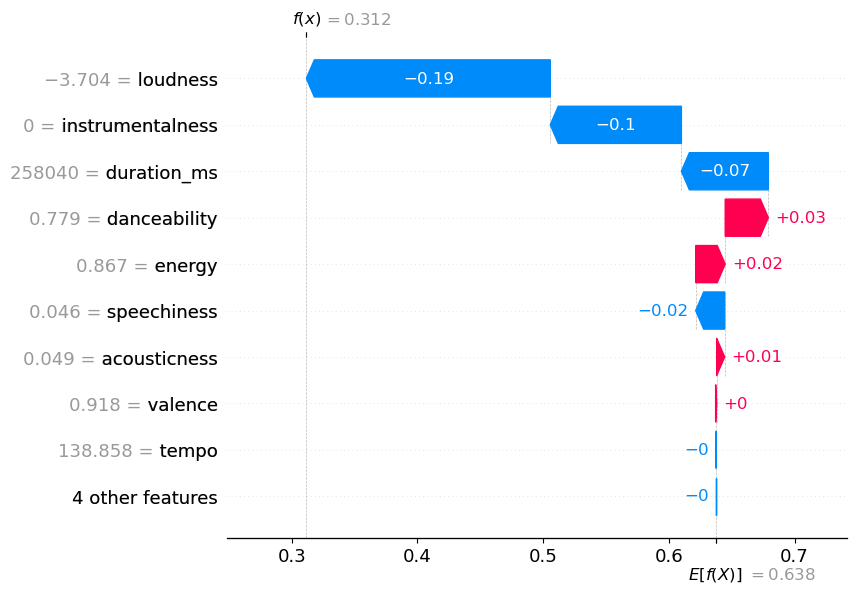

----------------------------------------------------------------------------------------------------------------------------

WORKING WITH INSTANCE 327:
The real output class is: False
The predicted output class by model TREE_songs is: True
Summary:


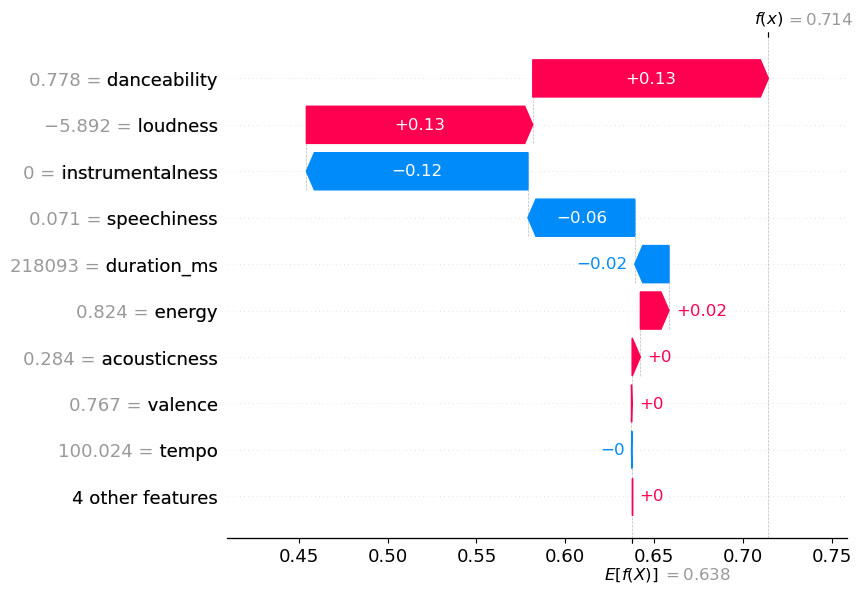

----------------------------------------------------------------------------------------------------------------------------

WORKING WITH INSTANCE 150:
The real output class is: False
The predicted output class by model TREE_songs is: True
Summary:


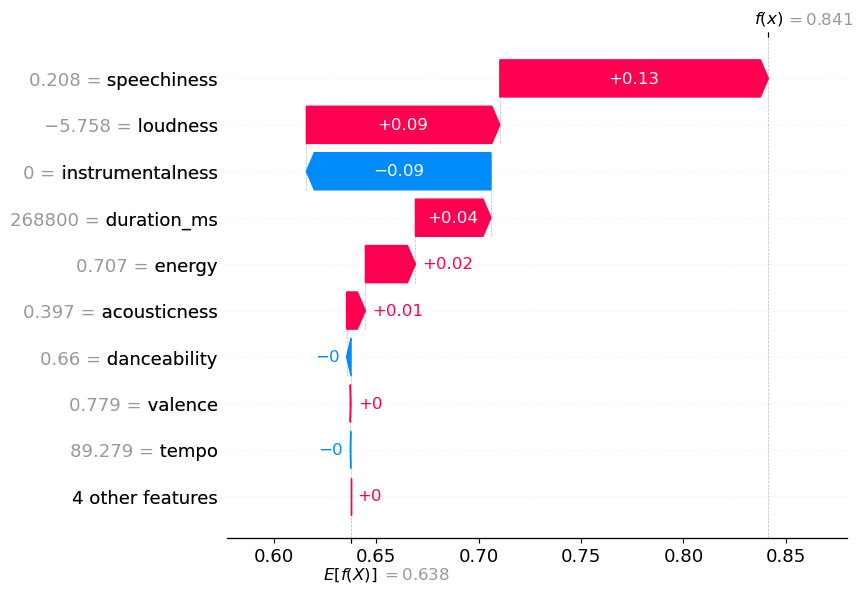

----------------------------------------------------------------------------------------------------------------------------

WORKING WITH INSTANCE 200:
The real output class is: False
The predicted output class by model TREE_songs is: False
Summary:


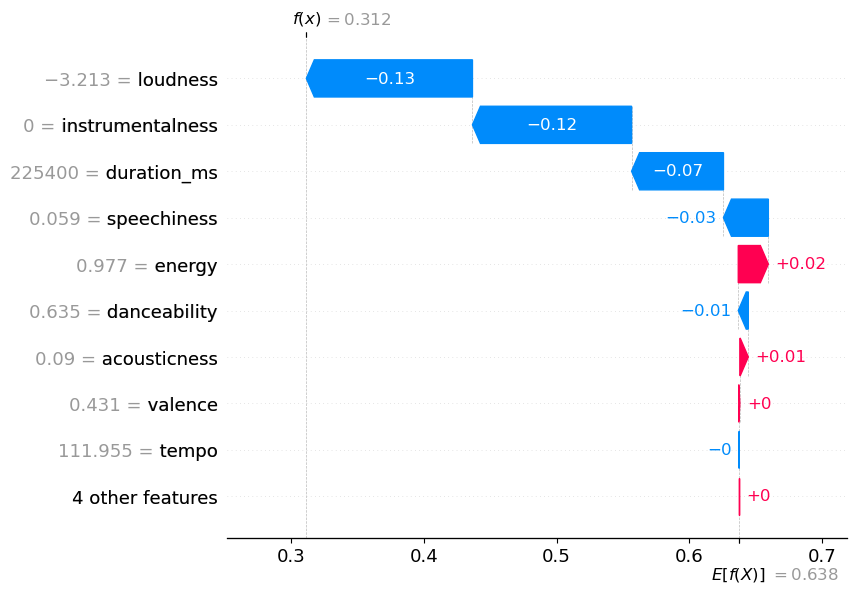

In [60]:
print("="*30,"Waterfall","="*30)
print("""
How to read the plot
- This is a SHAP waterfall plot explaining a serie of single predictions.
- The baseline value (E[f(X)]) represents the average model prediction across the dataset.
- Each bar shows how a feature moves the prediction from the baseline toward the final prediction f(x).
- Red bars indicate features that increase the prediction, while blue bars indicate features that decrease it.
- The length of each bar represents the magnitude of the contribution of that feature.
- Summing all contributions (positive and negative) starting from the baseline results in the final prediction value.
""")
instances_to_explain = [
    1828-1600,
    1927-1600,
    1750-1600,
    1800-1600
]

for instance in instances_to_explain: # specific cases, feel free to alter them
    print('----------------------------------------------------------------------------------------------------------------------------')
    print(f'\nWORKING WITH INSTANCE {instance}:\nThe real output class is: {y_songs_test.iloc[instance]}')
    

    
    
    for model, model_name, explainer in zip(models_songs, models_names_songs, explainers_songs):
        print(f'The predicted output class by model {model_name} is: {model.predict(X_songs_test.iloc[instance : instance+1])[0]}')
        shap_values = explainer(X_songs_test.iloc[instance : instance+1])
        
        shap_class = shap_values[:, :, 1]

        print("Summary:")
        
        # print("showing how each feature contributed to the model output.   ")
        # print("""
        # Interpretation of this plot

        # - loudness is the most important feature in the model ,it contributes 
        #   the most to prediction changes across the dataset.
        # - instrumentalness is the second most important feature .
        # - duration_ms also has a relevant impact .
        # - danceability, speechiness, and energy have moderate influence.
        # - acousticness has a small contribution.
        # - valence, tempo, and the remaining grouped features have almost no impact 
        # on the model predictions.

        # Tthe model relies  on loudness, instrumentalness, and duration_ms, 
        # while the rest of the variables play a smaller role.
        # """)
         
        # print("""
        # How to read the plot
        # 1. X-axis (SHAP value)
        # - Positive values (right) : feature increases the prediction
        # - Negative values (left) : feature decreases the prediction
        # - The distance from 0 indicates the strength of the impact
        # """)
        # print("""
        # 2. Color (feature value)
        # Color indicates the actual value of the feature for the instance:
        # - Red : high feature value
        # - Blue : low feature value
        # """)
        # shap.summary_plot(shap_class)
        
        # print("Bar:")
        # print("This plot shows the global feature importance based on SHAP values, averaged across all instances in the test set .\n It shows which features have more influence in the model's predictions.")

        # print("""
        # How to read the plot
        # - The x-axis (mean(|SHAP value|)) represents the average magnitude of the contribution 
        # of each feature to the model predictions.
        # - Larger bars : the feature has a stronger influence on the model.
        # - This plot shows importance, not if the feature increases or decreases predictions.
        # """)
  
        

        # shap.plots.bar(shap_class)
        
        # print("Waterfall:")
        # print("""
        # How to read the plot
        # - This is a SHAP waterfall plot explaining a single prediction.
        # - The baseline value (E[f(X)]) represents the average model prediction across the dataset.
        # - Each bar shows how a feature moves the prediction from the baseline toward the final prediction f(x).
        # - Red bars indicate features that increase the prediction, while blue bars indicate features that decrease it.
        # - The length of each bar represents the magnitude of the contribution of that feature.
        # - Summing all contributions (positive and negative) starting from the baseline results in the final prediction value.
        # """)

        shap.plots.waterfall(shap_class[0])

        # print("Partial dependence:")
        # shap.plots.partial_dependence("loudness", model.predict ,X_songs_test)
        # print('----------------------------------------------------------------------------------------------------------------------------')

# 6. **Sample Interpretations**

In [61]:
print("""
Plot 1 — Interpretation

- loudness is the most influential feature decreasing the prediction.
- instrumentalness is the second strongest negative contributor.
- duration_ms also decreases the prediction noticeably.
- danceability, energy, and acousticness provide small positive contributions.
- speechiness slightly decreases the prediction.
- valence, tempo, and the remaining grouped features have almost no impact.


Plot 2 — Interpretation

- danceability and loudness are the main features increasing the prediction.
- instrumentalness is the strongest feature decreasing the prediction.
- speechiness and duration_ms also contribute negatively but with smaller magnitude.
- energy provides a small positive contribution.
- acousticness, valence, tempo, and the remaining grouped features have negligible impact.


Plot 3 — Interpretation

- speechiness is the main feature increasing the prediction.
- loudness also contributes positively but with smaller magnitude.
- instrumentalness is the main feature decreasing the prediction.
- duration_ms, energy, and acousticness provide moderate positive contributions.
- danceability, valence, tempo, and the remaining grouped features have minimal influence.


Plot 4 — Interpretation

- loudness, instrumentalness, and duration_ms are the main features decreasing the prediction.
- speechiness also contributes negatively but with smaller magnitude.
- energy and acousticness slightly increase the prediction.
- danceability has a very small negative contribution.
- valence, tempo, and the remaining grouped features have almost no impact.
""")



Plot 1 — Interpretation

- loudness is the most influential feature decreasing the prediction.
- instrumentalness is the second strongest negative contributor.
- duration_ms also decreases the prediction noticeably.
- danceability, energy, and acousticness provide small positive contributions.
- speechiness slightly decreases the prediction.
- valence, tempo, and the remaining grouped features have almost no impact.


Plot 2 — Interpretation

- danceability and loudness are the main features increasing the prediction.
- instrumentalness is the strongest feature decreasing the prediction.
- speechiness and duration_ms also contribute negatively but with smaller magnitude.
- energy provides a small positive contribution.
- acousticness, valence, tempo, and the remaining grouped features have negligible impact.


Plot 3 — Interpretation

- speechiness is the main feature increasing the prediction.
- loudness also contributes positively but with smaller magnitude.
- instrumentalness is th